In [1]:
CODE_DIR = "/home/cbarkhof/fall-2021"
import sys
sys.path.append(CODE_DIR)

In [9]:
import os
import torch
import pandas as pd

from dataset_dataloader import get_n_data_samples_x_y
from analysis_run_postprocessing.general_postprocessing_steps import make_run_overview_df

In [3]:
N_LENGTHS = 2000

EXPORT_DIR = f"{CODE_DIR}/analysis_run_postprocessing/run_postprocess_files"
CHECKPOINT_DIR = f"{CODE_DIR}/run_files/checkpoints"

SAMPLE_FILE = f"generative-samples.pt"
CONDITIONAL_SAMPLE_FILE = f"generative-conditional-samples.pt"
ENCODING_FILE = "encodings.pt"

EVALUATION_RESULT_FILE = "evaluation-results.pt"
SURPRISAL_DATA_FILE = "surprisal_data.pt"

DEVICE = "cuda:0"

In [4]:
# ---------------------------------
# PTB
ptb_train_inputs, ptb_train_atts = get_n_data_samples_x_y(
    language_dataset_name="ptb",
    image_or_language="language", 
    shuffle=False,
    N_samples=N_LENGTHS, 
    phase="train")

ptb_valid_inputs, ptb_valid_atts = get_n_data_samples_x_y(
    language_dataset_name="ptb",
    image_or_language="language", 
    shuffle=False,
    N_samples=2560, #  <-- SET TO 2560
    phase="valid")

Is file!
train 42068
validation 3370
test 3761
Returns concatted input_ids, attention_masks tensors
Is file!
train 42068
validation 3370
test 3761
Returns concatted input_ids, attention_masks tensors


In [5]:
def get_length_of_chunk(chunk, eos_token_id=2, bos_token=0, remove_start=False):
    # Get length without start and end token (so index(eos) = length)
    
    lens = []
    for s_i in chunk.tolist():
        # if it is a weak decoder, the start token needs to be cut-off as well (if predicted)
        if s_i[0] == bos_token and remove_start:
            s_i = s_i[1:]
        length = s_i.index(eos_token_id) if eos_token_id in s_i else len(s_i)
        lens.append(length)
    return lens

In [6]:
ptb_valid_lens = get_length_of_chunk(ptb_valid_inputs, remove_start=True)
ptb_train_lens = get_length_of_chunk(ptb_train_inputs, remove_start=True)

1 62
1 62


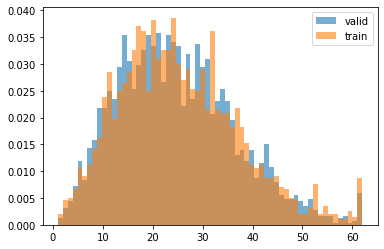

2560 2560
2000 2000


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print(min(ptb_valid_lens), max(ptb_valid_lens))
print(min(ptb_train_lens), max(ptb_train_lens))
plt.hist(ptb_valid_lens, bins=62, alpha=0.6, label="valid", density=True)
plt.hist(ptb_train_lens, bins=62, alpha=0.6, label="train", density=True)
plt.legend()
plt.show()

print(len(ptb_valid_lens), len(ptb_valid_inputs))
print(len(ptb_train_lens), len(ptb_train_inputs))

In [11]:
run_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/final_selection_runs.csv", index_col=0)
run_df = run_df[run_df.image_or_language == "language"]
run_df.head()

,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0.0,0,0,1,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0.0,0,0,10,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0.0,0,0,100,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa,INFO-VAE,0.5,ptb,language,0.0,0,0,1,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=1...."
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa,INFO-VAE,0.5,ptb,language,0.0,0,0,10,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=10..."


In [12]:
all_samples = dict()

for i, (idx, row) in enumerate(run_df.iterrows()):
    print(idx)
    print(row.run_name)
    
    save_dir = f"{EXPORT_DIR}/{row.run_name}"
    conditional_sample_file = f"{save_dir}/{CONDITIONAL_SAMPLE_FILE}"
    sample_file = f"{save_dir}/{SAMPLE_FILE}"
    
    if not (os.path.exists(conditional_sample_file) or os.path.exists(sample_file)):
        print("Samples not present for run, skipping")
    
    else:
        conditional_samples = torch.load(conditional_sample_file)
        samples = torch.load(sample_file)
        
        all_samples[idx] = dict(
            condition=conditional_samples["valid"]["original_input_ids"].cpu(),
            conditional_sample=conditional_samples["valid"]["cond_sample_x"].cpu(),
            sample=samples["x"].cpu()
        )

INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa
(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mmd=1.0] | STRONG | Nz=32
INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa
(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mmd=10.0] | STRONG | Nz=32
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa
(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mmd=100.0] | STRONG | Nz=32
INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa
(11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=1.0] | STRONG | Nz=32
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa
(11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=10.0] | STRONG | Nz=32
INFO-VAE l_Rate 0.5 l_MMD 100 dec: Strong roBERTa
(11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=100.0] | STRONG | Nz=32
INFO-VAE l_Rate 1 l_MMD 1 dec: Strong roBERTa
(11-jan ptb) INFO-VAE[l_1_rate=1.0, l_2_mmd=1.0] | STRONG | Nz=32
INFO-VAE l_Rate 1 l_MMD 10 dec: Strong roBERTa
(11-jan ptb) INFO-VAE[l_1_rate=1.0, l_2_mmd=10.0] | STRONG | Nz=32
INFO-VAE l_Rate 1 l_MMD 100 dec: Strong roBERTa
(11-jan ptb) INFO-

In [13]:
print("strong")
temp = all_samples["INFO-VAE l_Rate 0.5 l_MMD 100 dec: Strong roBERTa"]
print(len(temp["condition"][0]), temp["condition"][0])
print(len(temp["conditional_sample"][0]), temp["conditional_sample"][0])
print(len(temp["sample"][0]), temp["sample"][0])

# print()
# print("weak")
# temp = all_samples["INFO-VAE l_Rate 0.1 l_MMD 1 dec: Weak-M roBERTa"]
# print(len(temp["condition"][0]), temp["condition"][0])
# print(len(temp["conditional_sample"][0]), temp["conditional_sample"][0])
# print(len(temp["sample"][0]), temp["sample"][0])

strong
64 tensor([    0, 10998, 35954,   189,   236,     7,   517,    49,  8327, 15797,
           10,   410,  2789,     7,     5, 30016,   278,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])
63 tensor([  281,   444,    25,   385,  4189,   257,    34, 11464,    15,  2396,
         1717,     4,    29,     4, 12200, 12143,   181,   506,  6315,   784,
         2951,   212,  1253,   102,    16,     5,   471,     9,     5,   109,
        11192,  1933,     2,     2,  1278,     5, 22677,     8,   161,    24,
         1411,     7,  1437,     3,    98,   705,  5810,  1321,    40,   657,
           49, 14063,     7,  1095,    62,   454,  3859,     2,     2,     2,
            2,

In [14]:
all_lengths = dict()

for run_name, samples in all_samples.items():
    
    all_lengths[run_name] = dict()
    
    weak = False
    if "weak" in run_name.lower():
        weak = True
    
    for k, v in samples.items():
        
        # DATA SAMPLE
        if k == "condition":
            lengths = get_length_of_chunk(v, remove_start=True)
            
        # MODEL SAMPLE
        else:
            # to avoid lens > 62 only get the reasonable predictions
            if weak:
                # instead of remove start just chop of the first token
                lengths = get_length_of_chunk(v[:, 1:-1], remove_start=False) 
            else:
                lengths = get_length_of_chunk(v[:, :-1], remove_start=False)
        
        all_lengths[run_name][k] = lengths

## Check order of the validation set and the conditional samples

-> Should be all of the same length and same order!

In [15]:
for run_name, lengths in all_lengths.items():
    print(run_name)
    print(lengths["condition"][:20])
    print(len(lengths["condition"]))
    
    print()

print(ptb_valid_lens[:20])
print(len(ptb_valid_lens))

INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa
[16, 34, 24, 23, 21, 15, 31, 41, 20, 32, 34, 24, 31, 13, 42, 24, 12, 37, 16, 26]
2560

INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa
[16, 34, 24, 23, 21, 15, 31, 41, 20, 32, 34, 24, 31, 13, 42, 24, 12, 37, 16, 26]
2560

INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa
[16, 34, 24, 23, 21, 15, 31, 41, 20, 32, 34, 24, 31, 13, 42, 24, 12, 37, 16, 26]
2560

INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa
[16, 34, 24, 23, 21, 15, 31, 41, 20, 32, 34, 24, 31, 13, 42, 24, 12, 37, 16, 26]
2560

INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa
[16, 34, 24, 23, 21, 15, 31, 41, 20, 32, 34, 24, 31, 13, 42, 24, 12, 37, 16, 26]
2560

INFO-VAE l_Rate 0.5 l_MMD 100 dec: Strong roBERTa
[16, 34, 24, 23, 21, 15, 31, 41, 20, 32, 34, 24, 31, 13, 42, 24, 12, 37, 16, 26]
2560

INFO-VAE l_Rate 1 l_MMD 1 dec: Strong roBERTa
[16, 34, 24, 23, 21, 15, 31, 41, 20, 32, 34, 24, 31, 13, 42, 24, 12, 37, 16, 26]
2560

INFO-VAE l_Rate 1 l_MMD 10 dec: Strong roBERTa
[16,

In [18]:
all_lens = {
    "data_group": dict(train=ptb_train_lens, valid=ptb_valid_lens),
    "model_groups": all_lengths
}
torch.save(all_lens, "ptb_length_analysis_data.pt")

1 62


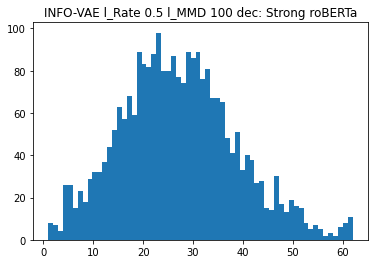

1 62


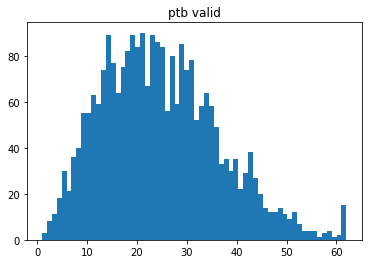

In [17]:
run_strong = "INFO-VAE l_Rate 0.5 l_MMD 100 dec: Strong roBERTa"
run_weak = "INFO-VAE l_Rate 0.1 l_MMD 1 dec: Weak-M roBERTa"

sample_type = "conditional_sample"
# sample_type = "sample"

plt.hist(all_lengths[run_strong][sample_type], bins=62)
print(min(all_lengths[run_strong][sample_type]), max(all_lengths[run_strong][sample_type]))
plt.title(run_strong)
plt.show()

# plt.hist(all_lengths[run_weak][sample_type], bins=62)
# print(min(all_lengths[run_weak][sample_type]), max(all_lengths[run_weak][sample_type]))
# plt.title(run_weak)
# plt.show()

plt.hist(ptb_valid_lens, bins=62)
print(min(ptb_valid_lens), max(ptb_valid_lens))
plt.title("ptb valid")
plt.show()